In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0 # Using a smaller EfficientNet variant
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import cv2 
import glob

2025-05-17 18:24:38.326452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747502678.339715   73005 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747502678.343551   73005 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747502678.354278   73005 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747502678.354295   73005 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747502678.354298   73005 computation_placer.cc:177] computation placer alr

In [2]:
# --- Configuration & Constants ---
BASE_DATASET_PATH = './k_CBIS-DDSM/'
CALC_METADATA_CSV_PATH = os.path.join(BASE_DATASET_PATH, 'calc_case(with_jpg_img).csv')
MASS_METADATA_CSV_PATH = os.path.join(BASE_DATASET_PATH, 'mass_case(with_jpg_img).csv')

IMAGE_ROOT_DIR = BASE_DATASET_PATH
ACTUAL_IMAGE_FILES_BASE_DIR = os.path.join(IMAGE_ROOT_DIR, 'jpg_img')

# Column in CSV that conceptually should point to ROIs, even if paths are flawed
CONCEPTUAL_ROI_COLUMN_NAME = 'jpg_ROI_img_path'
PATHOLOGY_COLUMN_NAME = 'pathology'
CASE_TYPE_COLUMN_NAME = 'case_type'


# Model & Training Parameters
IMG_WIDTH, IMG_HEIGHT = 224, 224 # EfficientNetB0 default input size
BATCH_SIZE = 32
EPOCHS = 50 # Initial epochs for head training
FINE_TUNE_EPOCHS = 20 # Additional epochs for fine-tuning
LEARNING_RATE = 1e-4
RANDOM_STATE = 42
# --- End of Configuration & Constants ---

In [3]:
print("--- Initial Path Configuration Debug ---")
print(f"Current working directory (CWD): {os.getcwd()}")
print(f"BASE_DATASET_PATH (relative from CWD as defined): {BASE_DATASET_PATH}")
print(f"CALC_METADATA_CSV_PATH (relative from CWD as defined): {CALC_METADATA_CSV_PATH}") # MODIFIED
print(f"MASS_METADATA_CSV_PATH (relative from CWD as defined): {MASS_METADATA_CSV_PATH}")   # ADDED
print(f"IMAGE_ROOT_DIR (relative from CWD as defined): {IMAGE_ROOT_DIR}")
print(f"ACTUAL_IMAGE_FILES_BASE_DIR (relative from CWD as defined): {ACTUAL_IMAGE_FILES_BASE_DIR}")

# Resolve to absolute paths for clarity and checking
abs_base_dataset_path = os.path.abspath(BASE_DATASET_PATH)
abs_calc_metadata_csv_path = os.path.abspath(CALC_METADATA_CSV_PATH) # MODIFIED
abs_mass_metadata_csv_path = os.path.abspath(MASS_METADATA_CSV_PATH)   # ADDED
abs_image_root_dir = os.path.abspath(IMAGE_ROOT_DIR)
abs_actual_image_files_base_dir = os.path.abspath(ACTUAL_IMAGE_FILES_BASE_DIR)

print(f"\nResolved BASE_DATASET_PATH to absolute: {abs_base_dataset_path}")
print(f"  -> Exists? {os.path.exists(abs_base_dataset_path)} | Is Dir? {os.path.isdir(abs_base_dataset_path)}")

print(f"Resolved CALC_METADATA_CSV_PATH to absolute: {abs_calc_metadata_csv_path}") # MODIFIED
print(f"  -> Exists? {os.path.exists(abs_calc_metadata_csv_path)} | Is File? {os.path.isfile(abs_calc_metadata_csv_path)}")

print(f"Resolved MASS_METADATA_CSV_PATH to absolute: {abs_mass_metadata_csv_path}")   # ADDED
print(f"  -> Exists? {os.path.exists(abs_mass_metadata_csv_path)} | Is File? {os.path.isfile(abs_mass_metadata_csv_path)}")

print(f"Resolved IMAGE_ROOT_DIR to absolute: {abs_image_root_dir}")
print(f"  -> Exists? {os.path.exists(abs_image_root_dir)} | Is Dir? {os.path.isdir(abs_image_root_dir)}")

print(f"Resolved ACTUAL_IMAGE_FILES_BASE_DIR (where series folders should be): {abs_actual_image_files_base_dir}")
print(f"  -> Exists? {os.path.exists(abs_actual_image_files_base_dir)} | Is Dir? {os.path.isdir(abs_actual_image_files_base_dir)}")

if os.path.exists(abs_actual_image_files_base_dir) and os.path.isdir(abs_actual_image_files_base_dir):
    print(f"\nSample contents of ACTUAL_IMAGE_FILES_BASE_DIR ('{abs_actual_image_files_base_dir}') (first 10 items):")
    try:
        sample_contents = os.listdir(abs_actual_image_files_base_dir)[:10]
        if not sample_contents:
            print("    -> Directory is empty or unreadable.")
        for item_idx, item in enumerate(sample_contents):
            item_abs_path = os.path.join(abs_actual_image_files_base_dir, item)
            item_type = "Dir" if os.path.isdir(item_abs_path) else "File" if os.path.isfile(item_abs_path) else "Other"
            print(f"    -> [{item_type}] {item}")
    except Exception as e:
        print(f"    -> Could not list directory contents: {e}")
else:
    print("\nCRITICAL WARNING: ACTUAL_IMAGE_FILES_BASE_DIR does not exist or is not a directory. Path searches will fail.")
print("--- End of Initial Path Configuration Debug ---\n")


# MODIFIED: Load and combine Calc and Mass CSVs
print("Proceeding with CSV loading...")
loaded_dfs = []

# Load Calc cases
if os.path.exists(abs_calc_metadata_csv_path):
    try:
        calc_df = pd.read_csv(abs_calc_metadata_csv_path)
        calc_df[CASE_TYPE_COLUMN_NAME] = 'calc' # Add case type identifier
        loaded_dfs.append(calc_df)
        print(f"Successfully loaded and tagged {len(calc_df)} rows from {CALC_METADATA_CSV_PATH}")
    except Exception as e:
        print(f"An error occurred while loading the CALC CSV ({CALC_METADATA_CSV_PATH}): {e}")
else:
    print(f"WARNING: CALC CSV file not found at {abs_calc_metadata_csv_path}. Skipping.")

# Load Mass cases
if os.path.exists(abs_mass_metadata_csv_path):
    try:
        mass_df = pd.read_csv(abs_mass_metadata_csv_path)
        mass_df[CASE_TYPE_COLUMN_NAME] = 'mass' # Add case type identifier
        loaded_dfs.append(mass_df)
        print(f"Successfully loaded and tagged {len(mass_df)} rows from {MASS_METADATA_CSV_PATH}")
    except Exception as e:
        print(f"An error occurred while loading the MASS CSV ({MASS_METADATA_CSV_PATH}): {e}")
else:
    print(f"WARNING: MASS CSV file not found at {abs_mass_metadata_csv_path}. Skipping.")

if not loaded_dfs:
    print("ERROR: No CSV files were loaded. Cannot proceed.")
    raise FileNotFoundError("Neither Calc nor Mass CSV files could be loaded. Check paths and file existence.")

source_df = pd.concat(loaded_dfs, ignore_index=True)
print(f"Combined DataFrame created with {len(source_df)} total rows from {len(loaded_dfs)} CSV file(s).")
print(f"Columns available in combined DataFrame: {source_df.columns.tolist()}")


# Clean and filter initial dataframe
if CONCEPTUAL_ROI_COLUMN_NAME not in source_df.columns or PATHOLOGY_COLUMN_NAME not in source_df.columns:
    print(f"ERROR: Required columns for metadata ('{CONCEPTUAL_ROI_COLUMN_NAME}' or '{PATHOLOGY_COLUMN_NAME}') not in combined CSV.")
    print(f"Available columns are: {source_df.columns.tolist()}")
    raise KeyError("Missing essential columns in combined CSV.")

source_df.dropna(subset=[CONCEPTUAL_ROI_COLUMN_NAME, PATHOLOGY_COLUMN_NAME], inplace=True)
source_df = source_df[source_df[PATHOLOGY_COLUMN_NAME].isin(['MALIGNANT', 'BENIGN'])]
print(f"Rows after initial cleaning (dropna on conceptual ROI/pathology, pathology filter): {len(source_df)}")

if source_df.empty:
    raise ValueError("Combined DataFrame is empty after initial cleaning. Cannot proceed.")

def heuristic_find_image_path(row, actual_images_root_dir_abs):
    try:
        patient_id = row['patient_id']
        breast_side = row['left or right breast']
        image_view = row['image view']
        abnormality_id = str(row['abnormality id']) # Ensure it's a string for concatenation

        csv_conceptual_roi_path = str(row.get(CONCEPTUAL_ROI_COLUMN_NAME, "")).strip()

        case_type_folder_prefix = ""
        if csv_conceptual_roi_path.startswith("jpg_img/"):
            path_part = csv_conceptual_roi_path.split('/')[1] # e.g., "Calc_Training_P_00005_..." or "Mass_Test_P_00001_..."
            # Extract the part before patient_id
            # The heuristic already includes Mass_Training and Mass_Test
            if path_part.startswith("Calc_Training_"): case_type_folder_prefix = "Calc_Training"
            elif path_part.startswith("Calc_Test_"): case_type_folder_prefix = "Calc_Test"
            elif path_part.startswith("Mass_Training_"): case_type_folder_prefix = "Mass_Training"
            elif path_part.startswith("Mass_Test_"): case_type_folder_prefix = "Mass_Test"

        if not case_type_folder_prefix:
            # print(f"DEBUG (heuristic): Could not determine case_type_folder_prefix for {patient_id} from '{csv_conceptual_roi_path}'")
            return None

        # Form search pattern for directories: e.g., /path/to/jpg_img/Calc_Training_P_00005_RIGHT_CC_1-*
        dir_search_prefix = f"{case_type_folder_prefix}_{patient_id}_{breast_side}_{image_view}_{abnormality_id}"
        full_dir_search_pattern = os.path.join(actual_images_root_dir_abs, f"{dir_search_prefix}-*")

        potential_series_dirs = glob.glob(full_dir_search_pattern)

        if not potential_series_dirs:
            # print(f"DEBUG (heuristic): No series directory found for {patient_id} with pattern '{full_dir_search_pattern}'")
            return None

        roi_filename_patterns = [
            "ROI-mask-images-img_0-*.jpg", "ROI-mask-images-img_1-*.jpg", "ROI-mask-images-img_*-*.jpg"
        ]

        for series_dir_on_disk in sorted(potential_series_dirs): # Sort to get a consistent choice if multiple match
            if os.path.isdir(series_dir_on_disk):
                for pattern in roi_filename_patterns:
                    image_search_glob = os.path.join(series_dir_on_disk, pattern)
                    found_roi_files = glob.glob(image_search_glob)
                    if found_roi_files:
                        found_roi_files.sort() # Sort to get a consistent choice
                        return found_roi_files[0] # Return the first valid ROI found
        return None
    except Exception as e:
        # print(f"DEBUG (heuristic): Error for row {row.get('patient_id', 'Unknown')} ({row.get(CASE_TYPE_COLUMN_NAME, 'N/A')} case): {e}")
        return None

print("Attempting HEURISTIC search for valid ROI paths for each CSV entry...")
source_df['full_image_path'] = source_df.apply(
    lambda r: heuristic_find_image_path(r, abs_actual_image_files_base_dir), axis=1
)

# All columns from source_df (including 'case_type' and any other original metadata)
# will be carried into metadata_df for rows where an image path was found.
metadata_df = source_df.dropna(subset=['full_image_path']).copy()
found_image_count = len(metadata_df)
print(f"Found {found_image_count} actual image files (ROIs if available) after HEURISTIC search from combined data.")
print(f"Breakdown by case type (if available in metadata_df): \n{metadata_df[CASE_TYPE_COLUMN_NAME].value_counts()}")


if found_image_count == 0:
    print("CRITICAL ERROR: Still no valid image files found even after heuristic search from combined data.")
    raise FileNotFoundError("No usable image files found even with heuristic search from combined data.")

metadata_df.rename(columns={'full_image_path': 'full_roi_path'}, inplace=True)

label_encoder = LabelEncoder()
# Ensure 'pathology_encoded' is created correctly on the copied DataFrame slice
metadata_df.loc[:, 'pathology_encoded'] = label_encoder.fit_transform(metadata_df[PATHOLOGY_COLUMN_NAME])
target_names = list(label_encoder.classes_)

# X will contain the image paths, y will contain the encoded labels.
# All other metadata columns (like 'patient_id', 'case_type', etc.) remain in metadata_df
# and can be used for deeper analysis or if a multi-input model is developed later.
X = metadata_df['full_roi_path']
y = metadata_df['pathology_encoded']
print(f"Number of samples going into train_test_split: {len(X)}")

if len(X) == 0:
     raise ValueError("Dataset is empty, cannot split.")

# Stratify by y to ensure balanced splits, especially important if classes are imbalanced
# or if combining datasets leads to different proportions.
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=RANDOM_STATE, stratify=y_train_val # Stratify this split too
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Print class distribution in each set to verify stratification
print(f"Train labels distribution: {np.bincount(y_train)}")
print(f"Validation labels distribution: {np.bincount(y_val)}")
print(f"Test labels distribution: {np.bincount(y_test)}")


def load_and_preprocess_image(image_path_tensor, label_tensor):
    # This function is wrapped by tf.py_function, so inputs are tensors.
    # Convert image_path_tensor to a Python string for cv2.imread
    image_path_str = image_path_tensor.numpy().decode('utf-8')

    try:
        img = cv2.imread(image_path_str)
        if img is None: # Check if image loading failed
            # print(f"Warning: Could not read image {image_path_str}. Returning dummy data.")
            dummy_img_array = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
            dummy_img_processed = tf.keras.applications.efficientnet.preprocess_input(dummy_img_array.copy())
            error_label = np.int32(-1) # Special label to indicate a problem
            return dummy_img_processed, error_label

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV loads as BGR, convert to RGB
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img_float32 = img.astype(np.float32)
        img_processed = tf.keras.applications.efficientnet.preprocess_input(img_float32)

        return img_processed, label_tensor.numpy().astype(np.int32)

    except Exception as e:
        # print(f"Error processing image {image_path_str}: {e}. Returning dummy data.")
        dummy_img_array = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        dummy_img_processed = tf.keras.applications.efficientnet.preprocess_input(dummy_img_array.copy())
        error_label = np.int32(-1) # Special label
        return dummy_img_processed, error_label


# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.1),
    tf.keras.layers.RandomContrast(factor=0.1)
])

def create_tf_dataset(image_paths, labels, batch_size, augment=False):
    image_paths_list = list(image_paths)
    labels_list = list(labels)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths_list, labels_list))

    dataset = dataset.map(lambda x, y: tf.py_function(
        load_and_preprocess_image,
        [x, y],
        [tf.float32, tf.int32]),
        num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.filter(lambda img_tensor, label_tensor: label_tensor != -1)

    def set_shape(img, label):
        img.set_shape((IMG_WIDTH, IMG_HEIGHT, 3))
        label.set_shape(())
        return img, label
    dataset = dataset.map(set_shape, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                              num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

print("Recreating TensorFlow datasets with updated image loading logic...")
train_dataset = create_tf_dataset(X_train, y_train, BATCH_SIZE, augment=True)
val_dataset = create_tf_dataset(X_val, y_val, BATCH_SIZE, augment=False)
test_dataset = create_tf_dataset(X_test, y_test, BATCH_SIZE, augment=False)

print("Verifying dataset integrity (this might take a moment)...")
train_batches = 0
train_samples_effective = 0
for images, labels in train_dataset:
    train_batches += 1
    train_samples_effective += labels.shape[0]
print(f"Number of batches in train_dataset: {train_batches}")
print(f"Effective number of samples in train_dataset after filtering: {train_samples_effective}")

if train_batches > 0:
    for images, labels in train_dataset.take(1):
        print("Sample batch shape from train_dataset:", images.shape, labels.shape)
else:
    print("Warning: train_dataset is empty after filtering. Check for widespread image loading issues.")

val_batches = 0
val_samples_effective = 0
for images, labels in val_dataset:
    val_batches +=1
    val_samples_effective += labels.shape[0]
print(f"Number of batches in val_dataset: {val_batches}")
print(f"Effective number of samples in val_dataset after filtering: {val_samples_effective}")


test_batches = 0
test_samples_effective = 0
for images, labels in test_dataset:
    test_batches += 1
    test_samples_effective += labels.shape[0]
print(f"Number of batches in test_dataset: {test_batches}")
print(f"Effective number of samples in test_dataset after filtering: {test_samples_effective}")


# Check if any dataset is empty, which could cause issues during training/evaluation
if train_samples_effective == 0 or val_samples_effective == 0:
    print("CRITICAL WARNING: Training or Validation dataset is empty after processing. Model training cannot proceed effectively.")
    # Depending on the severity, you might want to raise an error here
    # raise ValueError("Training or Validation dataset is empty.")


--- Initial Path Configuration Debug ---
Current working directory (CWD): /home/renato/Programming/CBIS-DDSM
BASE_DATASET_PATH (relative from CWD as defined): ./k_CBIS-DDSM/
CALC_METADATA_CSV_PATH (relative from CWD as defined): ./k_CBIS-DDSM/calc_case(with_jpg_img).csv
MASS_METADATA_CSV_PATH (relative from CWD as defined): ./k_CBIS-DDSM/mass_case(with_jpg_img).csv
IMAGE_ROOT_DIR (relative from CWD as defined): ./k_CBIS-DDSM/
ACTUAL_IMAGE_FILES_BASE_DIR (relative from CWD as defined): ./k_CBIS-DDSM/jpg_img

Resolved BASE_DATASET_PATH to absolute: /home/renato/Programming/CBIS-DDSM/k_CBIS-DDSM
  -> Exists? True | Is Dir? True
Resolved CALC_METADATA_CSV_PATH to absolute: /home/renato/Programming/CBIS-DDSM/k_CBIS-DDSM/calc_case(with_jpg_img).csv
  -> Exists? True | Is File? True
Resolved MASS_METADATA_CSV_PATH to absolute: /home/renato/Programming/CBIS-DDSM/k_CBIS-DDSM/mass_case(with_jpg_img).csv
  -> Exists? True | Is File? True
Resolved IMAGE_ROOT_DIR to absolute: /home/renato/Programmi

I0000 00:00:1747502703.853605   73005 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 982 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Verifying dataset integrity (this might take a moment)...


2025-05-17 18:25:18.085602: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of batches in train_dataset: 66
Effective number of samples in train_dataset after filtering: 2082
Sample batch shape from train_dataset: (32, 224, 224, 3) (32,)


2025-05-17 18:25:18.507496: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of batches in val_dataset: 12
Effective number of samples in val_dataset after filtering: 368
Number of batches in test_dataset: 14
Effective number of samples in test_dataset after filtering: 433


2025-05-17 18:25:22.610666: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# --- 2. Model Architecture ---
print("\nPhase 2: Building the Model")
base_model = EfficientNetB0(include_top=False, weights='imagenet',
                            input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_model.trainable = False # Start with base model frozen

inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = Dropout(0.3, name="top_dropout_1")(x)
x = Dense(128, activation='relu', name="dense_128")(x)
x = Dropout(0.3, name="top_dropout_2")(x)
outputs = Dense(1, activation='sigmoid', name="predictions")(x)
model = Model(inputs, outputs)


Phase 2: Building the Model


In [5]:
# --- 3. Model Compilation ---
print("\nPhase 3: Compiling the Model")
optimizer = Adam(learning_rate=LEARNING_RATE)

# MODIFIED: Adjust loss based on number of classes
if len(target_names) <= 2: # Binary classification (or single class if an error, but usually benign/malignant)
    loss = tf.keras.losses.BinaryCrossentropy()
    # For binary, ensure 'accuracy' is suitable. AUC, Precision, Recall are fine.
    metrics = ['accuracy', tf.keras.metrics.AUC(name='auc'),
               tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
else: # Multiclass classification
    loss = tf.keras.losses.SparseCategoricalCrossentropy() # Assuming y_train, etc., are integer labels
    metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')] # AUC might need `multi_label=True` or specific setup for multiclass
    # For multiclass, typical metrics are accuracy, sparse_categorical_accuracy.
    # Precision and Recall can be more complex (e.g., weighted, macro).
    # For simplicity, starting with accuracy and AUC.

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()



Phase 3: Compiling the Model


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_1 (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_2 (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
print("\nPhase 4: Training the Model (Head Only)")
# Ensure datasets are not empty before starting training
if train_samples_effective == 0 or val_samples_effective == 0:
    print("ERROR: Cannot start head training because train or validation dataset is empty.")
else:
    checkpoint_filepath_head = './best_model_head_only.keras'
    callbacks_head = [
        ModelCheckpoint(filepath=checkpoint_filepath_head, save_weights_only=False, monitor='val_auc', mode='max', save_best_only=True),
        EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True), # Increased patience
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, mode='min') # Increased patience
    ]
    history_head = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_head
    )
    print("Loading best weights from head training...")
    if os.path.exists(checkpoint_filepath_head):
        model.load_weights(checkpoint_filepath_head)
    else:
        print(f"Warning: Checkpoint file {checkpoint_filepath_head} not found. Using last model weights.")


# --- 4b. Fine-tuning Phase ---
print("\nPhase 4b: Fine-tuning (Unfreezing some base model layers)")
base_model.trainable = True

# Unfreeze layers from a certain block onwards in EfficientNetB0
# EfficientNetB0 has blocks named 'block2a_expand_conv', 'block3a_expand_conv', ..., 'block7a_expand_conv'
# We can choose to unfreeze from 'block6a' or 'block5a' onwards
# For this example, let's unfreeze from 'block5a' onwards.
# You might need to inspect `base_model.summary()` to choose the right layers.

# Fine-tuning strategy: Unfreeze more layers
# Set base_model.trainable = True first
# Then, selectively re-freeze earlier layers if desired
# For EfficientNet, it's common to unfreeze the top blocks.

fine_tune_at_layer_name = 'block6a_expand_conv' # Here we are just unfrezzing one
set_trainable = False
for layer in base_model.layers:
    if layer.name == fine_tune_at_layer_name:
        set_trainable = True
    if set_trainable:
        if not isinstance(layer, tf.keras.layers.BatchNormalization): # Keep BN frozen
            layer.trainable = True
        else:
            layer.trainable = False # Explicitly keep BN frozen
    else:
        layer.trainable = False


optimizer_fine_tune = Adam(learning_rate=LEARNING_RATE / 10) # Use a smaller LR
model.compile(optimizer=optimizer_fine_tune, loss=loss, metrics=metrics) # Re-compile
model.summary() # Show summary with new trainable params

if train_samples_effective == 0 or val_samples_effective == 0:
     print("ERROR: Cannot start fine-tuning because train or validation dataset is empty.")
else:
    checkpoint_filepath_finetune = './best_model_finetuned.keras'
    callbacks_finetune = [
        ModelCheckpoint(filepath=checkpoint_filepath_finetune, save_weights_only=False, monitor='val_auc', mode='max', save_best_only=True),
        EarlyStopping(monitor='val_auc', patience=15, mode='max', restore_best_weights=True), # Increased patience for fine-tuning
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8, mode='min') # Increased patience
    ]

    # Determine initial epoch for fine-tuning
    initial_fine_tune_epoch = 0
    if 'history_head' in locals() and hasattr(history_head, 'epoch') and history_head.epoch:
        initial_fine_tune_epoch = history_head.epoch[-1] + 1
    else: # If head training was skipped or history is unavailable
        initial_fine_tune_epoch = 0 # Or EPOCHS if you want to assume head training ran for all its epochs
        EPOCHS = 0 # Ensure we don't re-run head training if it was skipped

    history_fine_tune = model.fit(
        train_dataset,
        epochs=EPOCHS + FINE_TUNE_EPOCHS, # Total epochs
        initial_epoch=initial_fine_tune_epoch, # Continue from where head training left off
        validation_data=val_dataset,
        callbacks=callbacks_finetune
    )
    print("Loading best weights from fine-tuning...")
    if os.path.exists(checkpoint_filepath_finetune):
        model.load_weights(checkpoint_filepath_finetune)
    else:
        print(f"Warning: Checkpoint file {checkpoint_filepath_finetune} not found. Using last model weights from fine-tuning.")




Phase 4: Training the Model (Head Only)
Epoch 1/50


I0000 00:00:1747502730.549483   73237 service.cc:152] XLA service 0x7b5b30003580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747502730.549506   73237 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-05-17 18:25:31.181247: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747502732.495280   73237 cuda_dnn.cc:529] Loaded cuDNN version 90300


      2/Unknown 18s 56ms/step - accuracy: 0.6250 - auc: 0.6065 - loss: 0.6748 - precision: 0.6097 - recall: 1.0000

I0000 00:00:1747502741.846774   73237 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     66/Unknown 36s 276ms/step - accuracy: 0.5196 - auc: 0.5355 - loss: 0.7193 - precision: 0.5183 - recall: 0.6669

/home/renato/Programming/CBIS-DDSM/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-05-17 18:26:03.950921: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2092', 204 bytes spill stores, 204 bytes spill loads

2025-05-17 18:26:03.956519: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2092_0', 464 bytes spill stores, 1372 bytes spill loads

2025-05-17 18:26:04.388321: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are 

66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 520ms/step - accuracy: 0.5197 - auc: 0.5354 - loss: 0.7191 - precision: 0.5183 - recall: 0.6656 - val_accuracy: 0.5571 - val_auc: 0.5518 - val_loss: 0.6952 - val_precision: 0.7255 - val_recall: 0.1989 - learning_rate: 1.0000e-04
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.5468 - auc: 0.5557 - loss: 0.6977 - precision: 0.5548 - recall: 0.4928 - val_accuracy: 0.5679 - val_auc: 0.5845 - val_loss: 0.6855 - val_precision: 0.7015 - val_recall: 0.2527 - learning_rate: 1.0000e-04
Epoch 3/50
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5657 - auc: 0.5899 - loss: 0.6860 - precision: 0.5817 - recall: 0.4851

2025-05-17 18:26:46.735122: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.5657 - auc: 0.5898 - loss: 0.6860 - precision: 0.5814 - recall: 0.4865 - val_accuracy: 0.5462 - val_auc: 0.5957 - val_loss: 0.6786 - val_precision: 0.6022 - val_recall: 0.3011 - learning_rate: 1.0000e-04
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 225ms/step - accuracy: 0.5669 - auc: 0.5961 - loss: 0.6800 - precision: 0.5772 - recall: 0.5219 - val_accuracy: 0.5625 - val_auc: 0.6077 - val_loss: 0.6743 - val_precision: 0.6263 - val_recall: 0.3333 - learning_rate: 1.0000e-04
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 0.5604 - auc: 0.5932 - loss: 0.6800 - precision: 0.5752 - recall: 0.5046 - val_accuracy: 0.5489 - val_auc: 0.6137 - val_loss: 0.6717 - val_precision: 0.5962 - val_recall: 0.3333 - learning_rate: 1.0000e-04
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step - accuracy: 0.5696 - auc: 0.5979 - loss: 0.6793 - precision: 0.5842 - recall: 0.5020 - val_accuracy: 0.5625 - val_auc: 0.6156 - val_loss: 0.6736 

2025-05-17 18:27:40.796286: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.5751 - auc: 0.6090 - loss: 0.6709 - precision: 0.5892 - recall: 0.5123 - val_accuracy: 0.5652 - val_auc: 0.6215 - val_loss: 0.6695 - val_precision: 0.6354 - val_recall: 0.3280 - learning_rate: 1.0000e-04
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.5695 - auc: 0.6099 - loss: 0.6703 - precision: 0.5827 - recall: 0.5064 - val_accuracy: 0.5788 - val_auc: 0.6250 - val_loss: 0.6668 - val_precision: 0.6476 - val_recall: 0.3656 - learning_rate: 1.0000e-04
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.5910 - auc: 0.6216 - loss: 0.6647 - precision: 0.6072 - recall: 0.5293 - val_accuracy: 0.5842 - val_auc: 0.6286 - val_loss: 0.6651 - val_precision: 0.6542 - val_recall: 0.3763 - learning_rate: 1.0000e-04
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.5916 - auc: 0.6240 - loss: 0.6652 - precision: 0.6098 - recall: 0.5255 - val_accuracy: 0.5842 - val_auc: 0.6322 - val_loss: 0.6679

2025-05-17 18:29:30.647028: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.6017 - auc: 0.6502 - loss: 0.6553 - precision: 0.6271 - recall: 0.5147 - val_accuracy: 0.5842 - val_auc: 0.6320 - val_loss: 0.6620 - val_precision: 0.6634 - val_recall: 0.3602 - learning_rate: 1.0000e-04
Epoch 17/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 254ms/step - accuracy: 0.5921 - auc: 0.6283 - loss: 0.6628 - precision: 0.6060 - recall: 0.5415 - val_accuracy: 0.5897 - val_auc: 0.6353 - val_loss: 0.6605 - val_precision: 0.6699 - val_recall: 0.3710 - learning_rate: 1.0000e-04
Epoch 18/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 0.5941 - auc: 0.6370 - loss: 0.6569 - precision: 0.6189 - recall: 0.5036 - val_accuracy: 0.5897 - val_auc: 0.6363 - val_loss: 0.6606 - val_precision: 0.6636 - val_recall: 0.3817 - learning_rate: 1.0000e-04
Epoch 19/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 203ms/step - accuracy: 0.6177 - auc: 0.6624 - loss: 0.6461 - precision: 0.6441 - recall: 0.5362 - val_accuracy: 0.5870 - val_auc: 0.6405 - val_loss: 0.65

2025-05-17 18:32:54.698728: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - accuracy: 0.6008 - auc: 0.6647 - loss: 0.6466 - precision: 0.6255 - recall: 0.5142 - val_accuracy: 0.6033 - val_auc: 0.6560 - val_loss: 0.6552 - val_precision: 0.7273 - val_recall: 0.3441 - learning_rate: 1.0000e-04
Epoch 33/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.6301 - auc: 0.6617 - loss: 0.6512 - precision: 0.6645 - recall: 0.5376 - val_accuracy: 0.6005 - val_auc: 0.6573 - val_loss: 0.6554 - val_precision: 0.7294 - val_recall: 0.3333 - learning_rate: 1.0000e-04
Epoch 34/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.6105 - auc: 0.6556 - loss: 0.6527 - precision: 0.6465 - recall: 0.5033 - val_accuracy: 0.5924 - val_auc: 0.6578 - val_loss: 0.6560 - val_precision: 0.7195 - val_recall: 0.3172 - learning_rate: 1.0000e-04
Epoch 35/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step - accuracy: 0.6233 - auc: 0.6749 - loss: 0.6397 - precision: 0.6666 - recall: 0.5033 - val_accuracy: 0.6005 - val_auc: 0.6576 - val_loss: 0.65

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_1 (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_2 (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 3,293,981 (12.57 MB)

 Non-trainable params: 919,687 (3.51 MB)

Epoch 51/70
66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 461ms/step - accuracy: 0.6254 - auc: 0.6658 - loss: 0.6401 - precision: 0.6517 - recall: 0.5092 - val_accuracy: 0.5924 - val_auc: 0.6636 - val_loss: 0.6529 - val_precision: 0.7195 - val_recall: 0.3172 - learning_rate: 1.0000e-05
Epoch 52/70
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.6265 - auc: 0.6777 - loss: 0.6421 - precision: 0.6656 - recall: 0.5198 - val_accuracy: 0.6033 - val_auc: 0.6626 - val_loss: 0.6491 - val_precision: 0.7083 - val_recall: 0.3656 - learning_rate: 1.0000e-05
Epoch 53/70
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.6397 - auc: 0.6795 - loss: 0.6353 - precision: 0.6740 - recall: 0.5543 - val_accuracy: 0.5978 - val_auc: 0.6634 - val_loss: 0.6521 - val_precision: 0.7317 - val_recall: 0.3226 - learning_rate: 1.0000e-05
Epoch 54/70
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.6331 - auc: 0.6823 - loss: 0.6313 - precision: 0.6644 - recall: 0.5539 - val_accuracy: 0.6141 - val_auc: 0.6667 - va

2025-05-17 18:40:34.520634: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 208ms/step - accuracy: 0.6479 - auc: 0.6967 - loss: 0.6252 - precision: 0.6884 - recall: 0.5473 - val_accuracy: 0.6196 - val_auc: 0.6764 - val_loss: 0.6383 - val_precision: 0.7212 - val_recall: 0.4032 - learning_rate: 2.0000e-06
Epoch 65/70
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.6425 - auc: 0.7131 - loss: 0.6165 - precision: 0.6838 - recall: 0.5424 - val_accuracy: 0.6114 - val_auc: 0.6794 - val_loss: 0.6367 - val_precision: 0.7009 - val_recall: 0.4032 - learning_rate: 2.0000e-06
Epoch 66/70
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 0.6619 - auc: 0.7100 - loss: 0.6174 - precision: 0.6988 - recall: 0.5753 - val_accuracy: 0.6168 - val_auc: 0.6785 - val_loss: 0.6375 - val_precision: 0.7143 - val_recall: 0.4032 - learning_rate: 2.0000e-06
Epoch 67/70
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - accuracy: 0.6445 - auc: 0.7167 - loss: 0.6147 - precision: 0.6749 - recall: 0.5669 - val_accuracy: 0.6141 - val_auc: 0.6781 - val_loss: 0.63


Phase 5: Evaluating the Model on Test Set
     13/Unknown 2s 155ms/step - accuracy: 0.6249 - auc: 0.6846 - loss: 0.6194 - precision: 0.6400 - recall: 0.5081

2025-05-17 18:42:11.786342: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2092', 220 bytes spill stores, 220 bytes spill loads

2025-05-17 18:42:11.795116: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2092_0', 444 bytes spill stores, 1384 bytes spill loads

2025-05-17 18:42:11.982136: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2092', 8 bytes spill stores, 8 bytes spill loads

2025-05-17 18:42:12.395465: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2092', 5524 bytes spill stores, 5564 bytes spill loads

2025-05-17 18:42:12.513480: I e

14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 771ms/step - accuracy: 0.6272 - auc: 0.6890 - loss: 0.6171 - precision: 0.6499 - recall: 0.5046

Test Set Evaluation Results:
loss: 0.6025
compile_metrics: 0.6420
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 484ms/step

Classification Report (Test Set):
              precision    recall  f1-score   support

      BENIGN       0.60      0.80      0.69       215
   MALIGNANT       0.71      0.48      0.58       218

    accuracy                           0.64       433
   macro avg       0.66      0.64      0.63       433
weighted avg       0.66      0.64      0.63       433


Confusion Matrix (Test Set):
[[173  42]
 [113 105]]


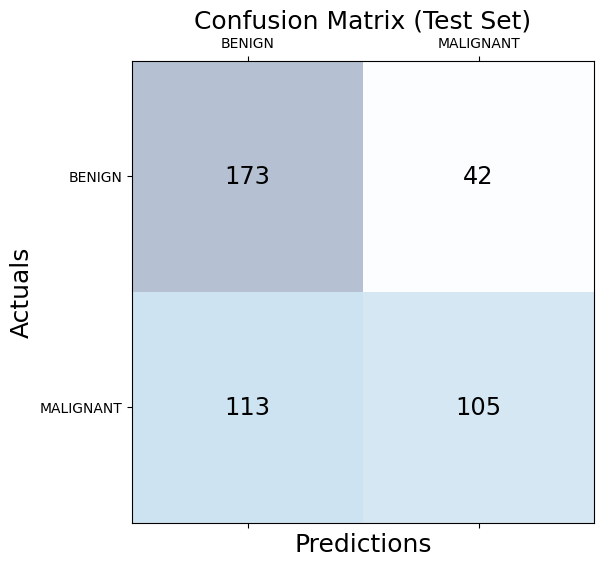

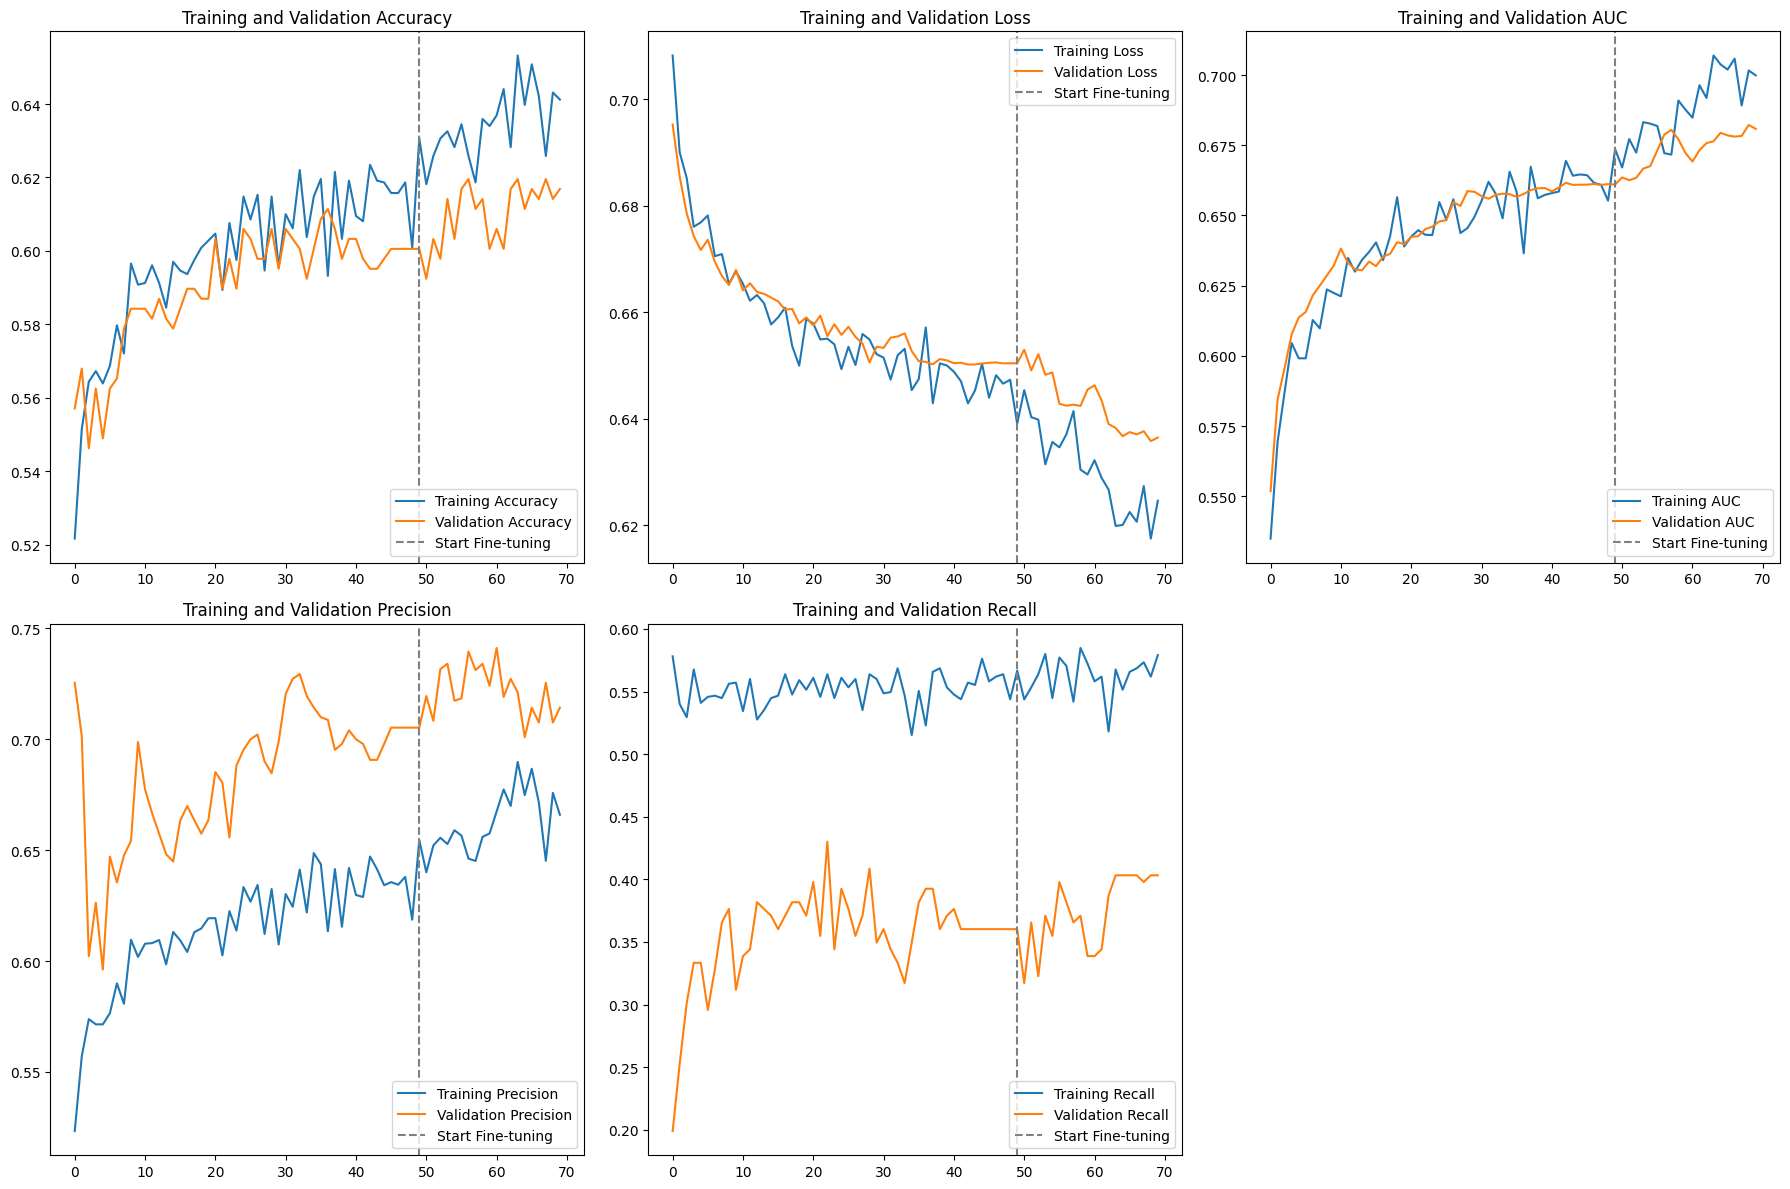


--- End of Script ---


In [ ]:
# --- 5. Model Evaluation ---
print("\nPhase 5: Evaluating the Model on Test Set")

if test_samples_effective == 0:
    print("ERROR: Test dataset is empty. Cannot evaluate model.")
else:
    results = model.evaluate(test_dataset, verbose=1)
    print("\nTest Set Evaluation Results:")
    if results and hasattr(model, 'metrics_names'):
        for name, value in zip(model.metrics_names, results):
            print(f"{name}: {value:.4f}")
    else:
        print("Evaluation did not return results or model has no metrics_names.")

    y_pred_proba = model.predict(test_dataset)

    # Extract true labels correctly, regardless of whether test_dataset was batched
    y_true_test = []
    for _, labels_batch in test_dataset.unbatch().batch(BATCH_SIZE): # Re-batch after unbatching to iterate easily
        y_true_test.extend(labels_batch.numpy())
    y_true_test = np.array(y_true_test)

    if len(target_names) <= 2: # Binary classification
        y_pred_classes = (y_pred_proba > 0.5).astype(int).flatten()
    else: # Multiclass classification
        y_pred_classes = np.argmax(y_pred_proba, axis=1)


    if len(y_true_test) == 0:
        print("Warning: No true labels extracted from the test set. Cannot generate classification report or confusion matrix.")
    elif len(y_true_test) != len(y_pred_classes):
         print(f"Warning: Mismatch in number of true labels ({len(y_true_test)}) and predicted classes ({len(y_pred_classes)}). Skipping report/matrix.")
    else:
        print("\nClassification Report (Test Set):")
        # Ensure target_names are correctly mapped if using numerical labels for the report
        # For binary, target_names = ['BENIGN', 'MALIGNANT'] (or whatever label_encoder found)
        # For multiclass, ensure it matches the numerically encoded classes
        print(classification_report(y_true_test, y_pred_classes, target_names=target_names, labels=range(len(target_names))))


        cm = confusion_matrix(y_true_test, y_pred_classes, labels=range(len(target_names)))
        print("\nConfusion Matrix (Test Set):")
        print(cm)

        plt.figure(figsize=(6,6))
        ax = plt.gca()
        ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix (Test Set)', fontsize=18)
        ax.set_xticks(range(len(target_names)))
        ax.set_yticks(range(len(target_names)))
        ax.set_xticklabels(target_names)
        ax.set_yticklabels(target_names)
        plt.show()


# Plot Training History (combined)
# Ensure histories exist before trying to plot
acc, val_acc, loss_hist, val_loss_hist, auc, val_auc = [], [], [], [], [], []
epochs_range_head_len = 0

if 'history_head' in locals() and hasattr(history_head, 'history'):
    acc.extend(history_head.history.get('accuracy', []))
    val_acc.extend(history_head.history.get('val_accuracy', []))
    loss_hist.extend(history_head.history.get('loss', []))
    val_loss_hist.extend(history_head.history.get('val_loss', []))
    auc.extend(history_head.history.get('auc', []))
    val_auc.extend(history_head.history.get('val_auc', []))
    epochs_range_head_len = len(history_head.history.get('accuracy', []))


if 'history_fine_tune' in locals() and hasattr(history_fine_tune, 'history'):
    acc.extend(history_fine_tune.history.get('accuracy', []))
    val_acc.extend(history_fine_tune.history.get('val_accuracy', []))
    loss_hist.extend(history_fine_tune.history.get('loss', []))
    val_loss_hist.extend(history_fine_tune.history.get('val_loss', []))
    auc.extend(history_fine_tune.history.get('auc', []))
    val_auc.extend(history_fine_tune.history.get('val_auc', []))

epochs_range_total = range(len(acc))

if epochs_range_total: # Only plot if there's history
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 3, 1)
    plt.plot(epochs_range_total, acc, label='Training Accuracy')
    plt.plot(epochs_range_total, val_acc, label='Validation Accuracy')
    if epochs_range_head_len > 0 and epochs_range_head_len < len(epochs_range_total):
        plt.axvline(x=epochs_range_head_len -1 , color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 3, 2)
    plt.plot(epochs_range_total, loss_hist, label='Training Loss')
    plt.plot(epochs_range_total, val_loss_hist, label='Validation Loss')
    if epochs_range_head_len > 0 and epochs_range_head_len < len(epochs_range_total):
        plt.axvline(x=epochs_range_head_len -1, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 3, 3)
    plt.plot(epochs_range_total, auc, label='Training AUC')
    plt.plot(epochs_range_total, val_auc, label='Validation AUC')
    if epochs_range_head_len > 0 and epochs_range_head_len < len(epochs_range_total):
        plt.axvline(x=epochs_range_head_len-1, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation AUC')

    # Add precision and recall plots if desired and available
    precision, val_precision, recall, val_recall = [], [], [], []
    if 'history_head' in locals() and hasattr(history_head, 'history'):
        precision.extend(history_head.history.get('precision', []))
        val_precision.extend(history_head.history.get('val_precision', []))
        recall.extend(history_head.history.get('recall', []))
        val_recall.extend(history_head.history.get('val_recall', []))
    if 'history_fine_tune' in locals() and hasattr(history_fine_tune, 'history'):
        precision.extend(history_fine_tune.history.get('precision', []))
        val_precision.extend(history_fine_tune.history.get('val_precision', []))
        recall.extend(history_fine_tune.history.get('recall', []))
        val_recall.extend(history_fine_tune.history.get('val_recall', []))


    if precision: # Check if precision was recorded
        plt.subplot(2, 3, 4)
        plt.plot(epochs_range_total, precision, label='Training Precision')
        plt.plot(epochs_range_total, val_precision, label='Validation Precision')
        if epochs_range_head_len > 0 and epochs_range_head_len < len(epochs_range_total):
            plt.axvline(x=epochs_range_head_len-1, color='gray', linestyle='--', label='Start Fine-tuning')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Precision')

    if recall: # Check if recall was recorded
        plt.subplot(2, 3, 5)
        plt.plot(epochs_range_total, recall, label='Training Recall')
        plt.plot(epochs_range_total, val_recall, label='Validation Recall')
        if epochs_range_head_len > 0 and epochs_range_head_len < len(epochs_range_total):
            plt.axvline(x=epochs_range_head_len-1, color='gray', linestyle='--', label='Start Fine-tuning')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Recall')

    plt.tight_layout()
    plt.show()
else:
    print("No training history found to plot.")

print("\n--- End of Training ---")
